In [4]:
import math
import numpy as np
from tletools import TLE
import matplotlib.pyplot as plt
import pandas as pd

inc - наклонение в градусах  
raan - долгота восходящего узла  
M - средняя аномалия в градусах  
ecc - эксцентриситет   
argp - аргумент перегея

### ECI:

In [35]:
t1 = np.datetime64('2021-09-16T00:00:00')
t2 = np.datetime64('2021-09-16T23:59:00')

step = np.timedelta64(1, 'h')

In [36]:
R = 6378.137e3
gamma = 6.674e-11
Me = 5.97e24

In [37]:
def _get_tle(path: str) -> TLE:
    with open(path, 'r') as file_tle:
        return TLE.from_lines(*file_tle.readlines())

tle = _get_tle("NOAA19.txt")

i = tle.inc * math.pi / 180
e = tle.ecc 
n = tle.n * 2 * math.pi / (3600 * 24)
W = tle.raan * math.pi / 180
w = tle.argp * math.pi / 180
M = tle.M * math.pi / 180
epoch = tle.epoch.value

In [38]:
def _get_matr_A(i, w, W):
    A = np.array([[math.cos(W), -math.sin(W), 0], [math.sin(W), math.cos(W), 0], [0, 0, 1]])
    B = np.array([[1, 0, 0],[0, math.cos(i), -math.sin(i)],[0, math.sin(i), math.cos(i)]])
    C = np.array([[math.cos(w), -math.sin(w), 0], [math.sin(w), math.cos(w), 0], [0, 0, 1]])
    return (A.dot(B)).dot(C)

def _get_orbital_coord(t, epoch, n, e):
    # координаты спутника в плоскости орбиты
    gamma = 6.674e-11
    Me = 5.97e24
    
    dt = ((t-epoch)/np.timedelta64(1, 's'))
    M = n*dt
    E = _get_E(e, M, 1e-6)
    a = math.pow(gamma*Me / (n*n), 1.0/3.0)
    b = a*math.sqrt(1 - e*e)

    x = a*math.cos(E)
    y = b*math.sin(E)
    res = np.zeros((3))
    res[0] = x
    res[1] = y
    res[2] = 0.0
    return res

def _get_E(e, M, dE=1e-6):
    E1 = 0.0
    E2 = e*math.sin(E1) + M
    while(abs(E2-E1) > dE):
        E1 = E2
        E2 = e*math.sin(E1) + M
    return E2

def _get_coordinats_ECI(t1, epoch, n, e):
    coords = _get_orbital_coord(t1, epoch, n, e)
    A = _get_matr_A(i, w, W)
    return A.dot(coords)

def get_orbit(t_start, t_end, step):
    x = []
    y = []
    z = []
    coord = _get_coordinats_ECI(t_start, epoch, n, e)
    x.append(coord[0])
    y.append(coord[1])
    z.append(coord[2])
    t = t_start + step
    while t < t_end:
        coord = _get_coordinats_ECI(t, epoch, n, e)
        x.append(coord[0])
        y.append(coord[1])
        z.append(coord[2])
        t += step
        
    return [x, y, z]

def draw_orbit(orbit):
    for an in range(0, 360, 30):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.set_xlim([-2*R, 2*R])
        ax.set_ylim([-2*R, 2*R])
        ax.set_zlim([-2*R, 2*R])
        ax.view_init(elev=0.0, azim=an)
        ax.plot(orbit[0], orbit[1], orbit[2] , 'r.')


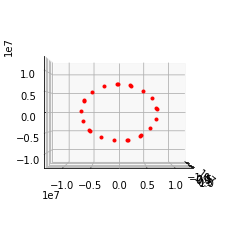

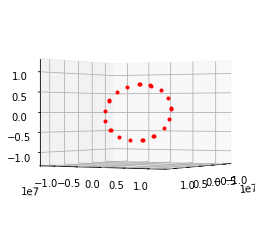

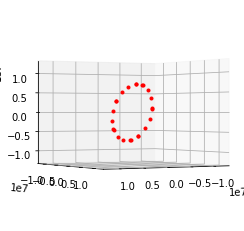

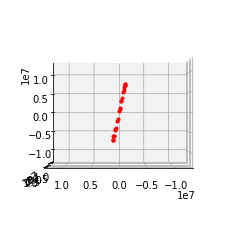

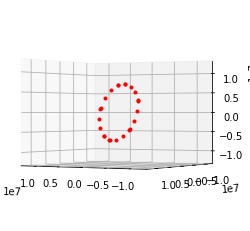

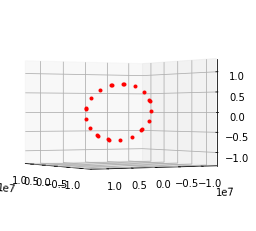

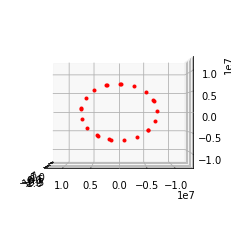

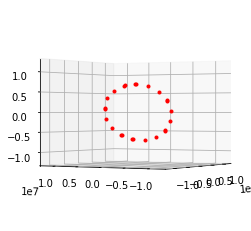

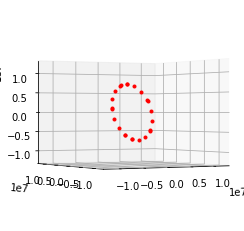

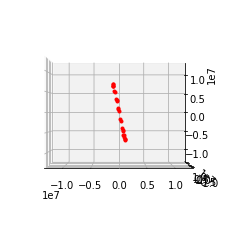

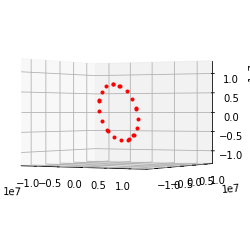

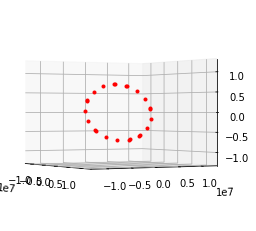

In [39]:
orbit = get_orbit(t1, t2, step)

draw_orbit(orbit)

### ECEF:

In [40]:
def ECI_to_ECEF(coord, epoch, t):
    angle = (360.9/ (24 * 60 * 60)) * ((t - epoch)/np.timedelta64(1, 's'))
    angle = math.radians(angle)
    A = np.array([[math.cos(angle), -math.sin(angle), 0],
                  [math.sin(angle), math.cos(angle), 0],
                  [0,0,1]])
    return A.dot(coord)

In [41]:
orbit = get_orbit(t1, t2, step)
x,y,z = orbit
t_list = []
while t1 < t2:
    t_list.append(t1)
    t1 += step

    
new_x, new_y, new_z = [], [], []
for i in range(len(x)):
    new_coord = ECI_to_ECEF(np.array([x[i],y[i],z[i]]), epoch, t_list[i])
    new_x.append(new_coord[0])
    new_y.append(new_coord[1])
    new_z.append(new_coord[2])

ECEF_orbit = np.array([new_x, new_y, new_z])

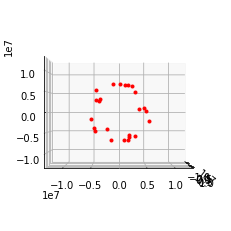

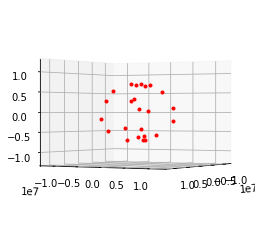

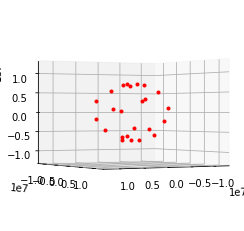

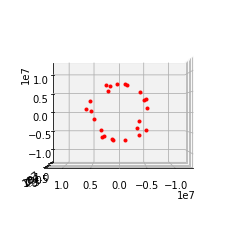

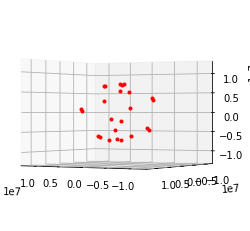

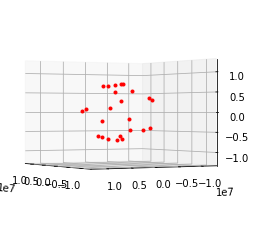

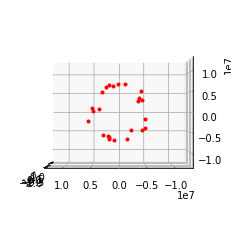

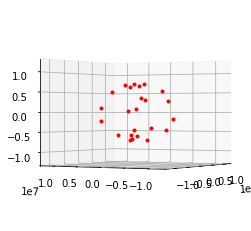

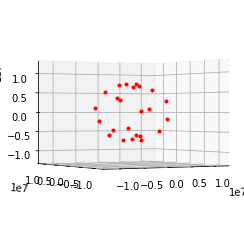

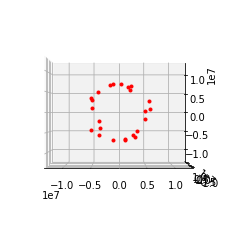

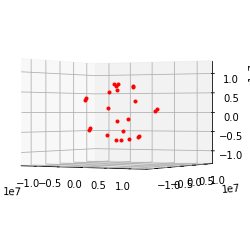

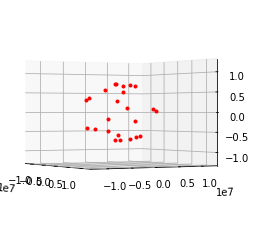

In [42]:
draw_orbit(ECEF_orbit)

### Видно или не видно

Как определяем видно или нет:

(все в ECEF)
получаем координаты спутника и ЛК
начиная с ЛК итерируемся по точкам на прямой, соединяющей ЛК и спутник    
если длина вектора до какой то точки на этой прямой меньше радиуса земли,
то прямая пересекает землю и мы не видим спутник
если нет, то мы доходим до спутника и переходим на следующий шаг итерации

В итоге если хотя бы для одна точка на этой прямой лежит в земле или пересекается с землей, то в этот момент времени спутник не видно

In [43]:
def lon_lat_to_ECEF(teta, fi, r):
   xd = r*math.sin(math.radians(teta))*math.cos(math.radians(fi))
   yd = r*math.sin(math.radians(teta))*math.sin(math.radians(fi))
   zd = r*math.cos(math.radians(teta))
   return np.array([xd, yd, zd])


In [44]:
LK_ECEF = lon_lat_to_ECEF(37.517, 55.93, R)

In [45]:
def find_direction(coord_sattelite, coord_LK):
    return (coord_sattelite - coord_LK)/get_len(coord_sattelite - coord_LK)

def get_len(coords):
    return math.sqrt(coords[0]**2 + coords[1]**2 + coords[2]**2)

def validation(S, LK):
    step = 10000
    begunok = LK.copy()
    direction = find_direction(S, LK)
    counter = 0
    while get_len(begunok - S) > 100000:
        counter += 1
        if get_len(begunok) < R - 200000:
            return False
        begunok += step * direction
    return True

def find_view_time(s_orbit, lk_coords, time_list):
    ans = []
    x, y, z = s_orbit[0], orbit[1], orbit[2]
    for i in range(len(time_list)):
        s_coords = np.array([x[i], y[i], z[i]])
        ans.append(validation(s_coords, lk_coords))
    return ans

In [46]:
ans = find_view_time(ECEF_orbit, LK_ECEF, t_list)

pd.DataFrame(t_list, ans)


,0
False,2021-09-16 00:00:00
True,2021-09-16 01:00:00
False,2021-09-16 02:00:00
False,2021-09-16 03:00:00
False,2021-09-16 04:00:00
False,2021-09-16 05:00:00
True,2021-09-16 06:00:00
False,2021-09-16 07:00:00
False,2021-09-16 08:00:00
False,2021-09-16 09:00:00
